In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
#Import and install all necessary packages and libraries
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

In [7]:
#Now we want to download the necessary images we want to classify - in this case drought vs non drought
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"looking for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [8]:
#We now want a list of drought photos urls held in urls list
urls = search_images('drought photos', max_images=5)
urls[1]

looking for 'drought photos'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://www.thesourcemagazine.org/wp-content/uploads/sites/4/2018/07/13_drought_1.jpg'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


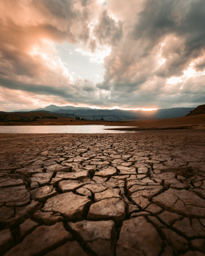

In [9]:
#Next, download the drought images using URL and take a look using fastai.vision
from fastdownload import download_url
dest = 'drought.jpg'
download_url(urls[4], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

looking for 'lush landscape photo'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


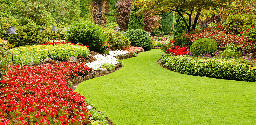

In [10]:
#Same for lush landscapes (non-drought)
download_url(search_images('lush landscape photo', max_images=5)[0], 'landscape.jpg', show_progress=False)
Image.open('landscape.jpg').to_thumb(256, 256)

In [11]:
searches = 'drought', 'lush landscape'
path = Path('drought_or_not')
from time import sleep

for obj in searches:
    #create path for each search category and make them folders
    dest = (path/obj)
    dest.mkdir(exist_ok=True, parents=True)
    #download images to these folders
    download_images(dest, urls=search_images(f'{obj} photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{obj} satellite photo'))
    sleep(10)
    resize_images(path/obj, max_size=400, dest=path/obj)
    

looking for 'drought photo'
looking for 'drought satellite photo'
looking for 'lush landscape photo'
looking for 'lush landscape satellite photo'


In [15]:
#Verify the pictures are not broken, if broken unlink them to discard
failed_pics = verify_images(get_image_files(path))
failed_pics.map(Path.unlink)
len(failed_pics)

0

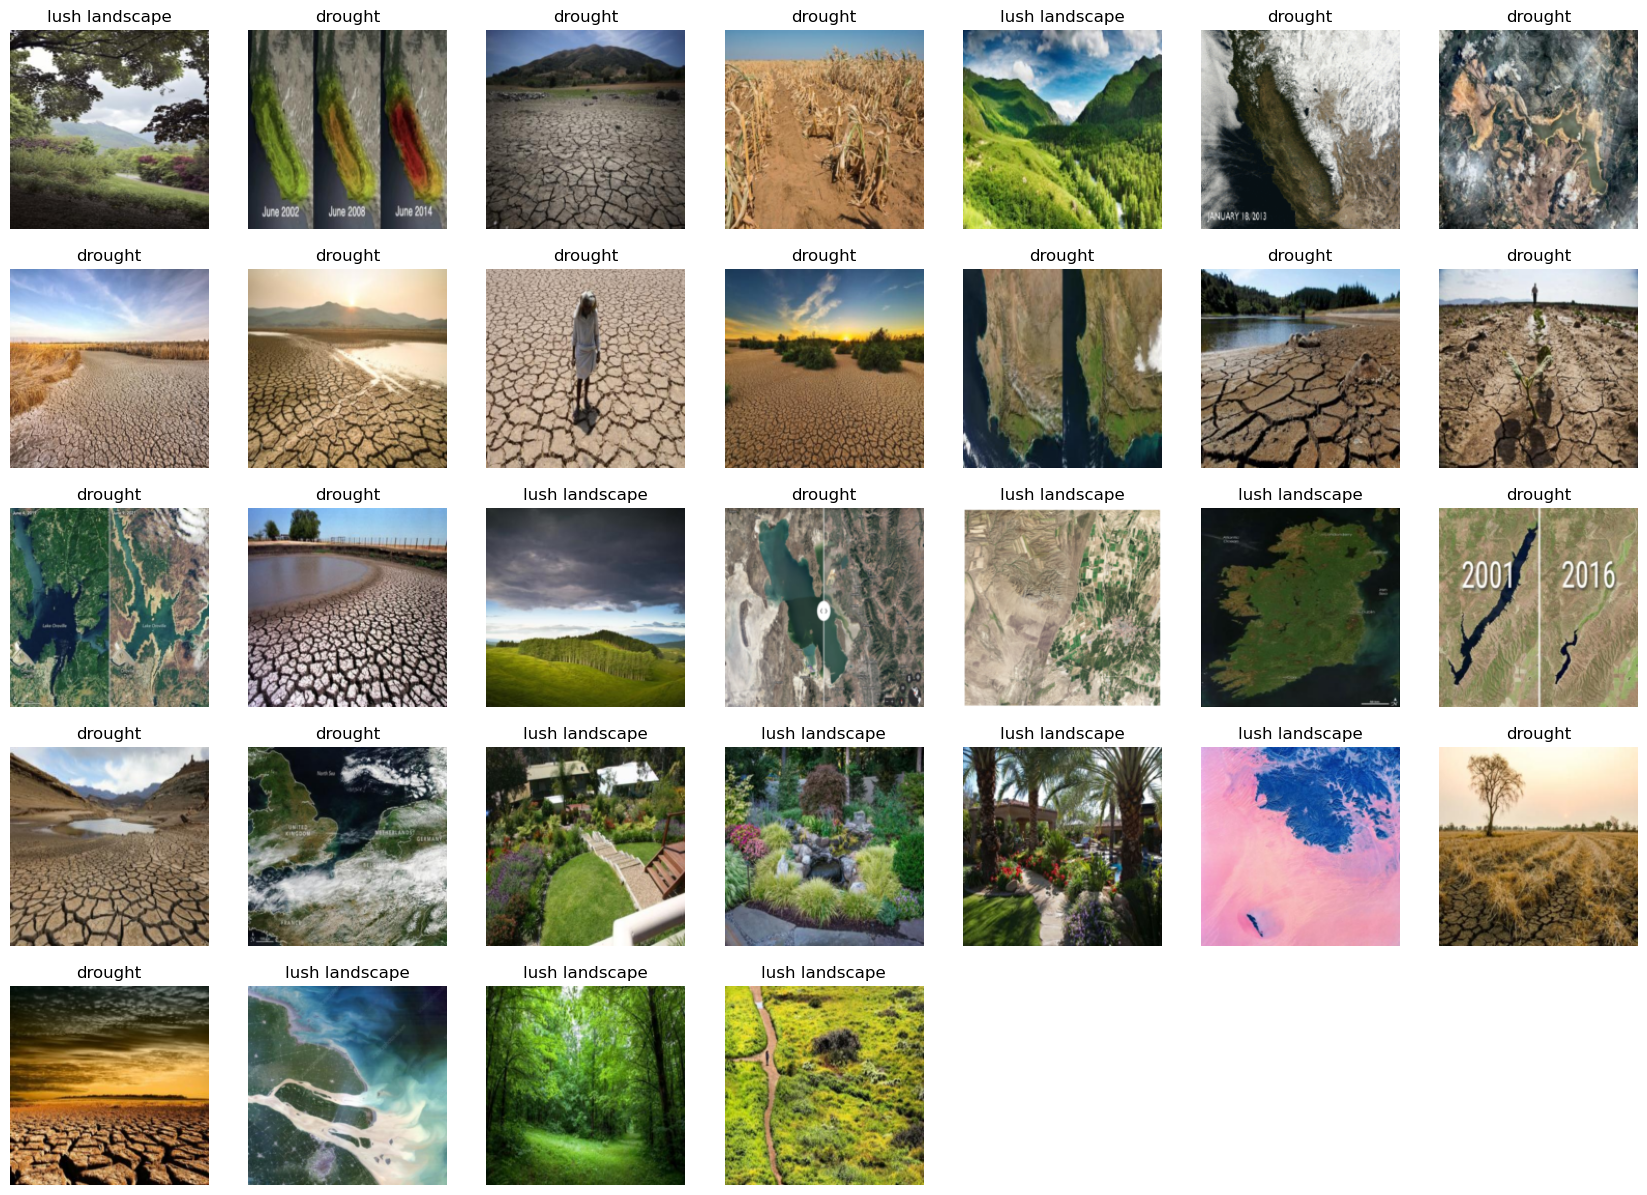

In [18]:
#now we need to create an object containing a training and validation set - DataLoaders

dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=200)

In [20]:
#now we will train our model using the computer vision model resnet18

mdl = vision_learner(dls, resnet18, metrics=error_rate)
mdl.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.356572,1.938084,0.500000,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.927924,1.635076,0.500000,00:12
1,0.759435,1.304898,0.454545,00:13
2,0.606381,1.062728,0.272727,00:13


In [30]:
isdrought,_,probs = mdl.predict(PILImage.create('drought.jpg'))
print(f"This is a: {isdrought}.")
print(f"The probability that its drought: {probs[0]:.3f}")

This is a: drought.
The probability that its drought: 1.000
